## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

1) 
       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0        1     0          123  3869200167        2374        26
1        1     0          124  3869200167        2374        27
2        1     0           63  3869200167        2553        28
3        1     0           64  3869200167        2558        19
4        1     0           64  3869200167        2760        25
...    ...   ...          ...         ...         ...       ...
7996     1     0           38  3869200246        3541        20
7997     1     0           63  3869200246        3550        14
7998     1     0           74  3869200246        3551         6
7999     1     0           69  3869200246        3550        16
8000     1     0           63  3869200247           0        19

[8001 rows x 6 columns]

2) Number of bx counts in an orbit: 3550

3) Total time 3.658677500000005 seconds



<ipython-input-14-bbcd41f87933>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Absolute time (ns)']=None
<ipython-input-14-bbcd41f87933>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Absolute time (ns)'][0]=25./30.*df['TDC_MEAS'][0]+25*df['BX_COUNTER'][0]
C:\Users\Utente\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

4) 
       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0        1     0          123  3869200167        2374        26   
1        1     0          124  3869200167        2374        27   
2        1     0           63  3869200167        2553        28   
3        1     0           64  3869200167        2558        19   
4        1     0           64  3869200167        2760        25   
...    ...   ...          ...         ...         ...       ...   
7996     1     0           38  3869200246        3541        20   
7997     1     0           63  3869200246        3550        14   
7998     1     0           74  3869200246        3551         6   
7999     1     0           69  3869200246        3550        16   
8000     1     0           63  3869200247           0        19   

     Absolute time (ns)  
0               59371.7  
1               59372.5  
2               63848.3  
3               63965.8  
4               69020.8  
...                 ...  
7996    

C:\Users\Utente\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


5) 
 0       0
1       1
2       0
3       0
4       1
       ..
7996    0
7997    0
7998    1
7999    0
8000    0
Name: HEAD, Length: 8001, dtype: int64

6) Data frame with only rows HEAD=1 
       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
1        1     0          124  3869200167        2374        27   
4        1     0           64  3869200167        2760        25   
5        1     0           63  3869200167        2762         4   
9        1     0           60  3869200167        2788         7   
10       1     1            7  3869200167        2785         4   
...    ...   ...          ...         ...         ...       ...   
7989     1     0           36  3869200246        3546         0   
7990     1     0           72  3869200246        3539         9   
7992     1     1           29  3869200246        3550         9   
7995     1     0           35  3869200246        3550        28   
7998     1     0           74  3869200246        3551         6   

  

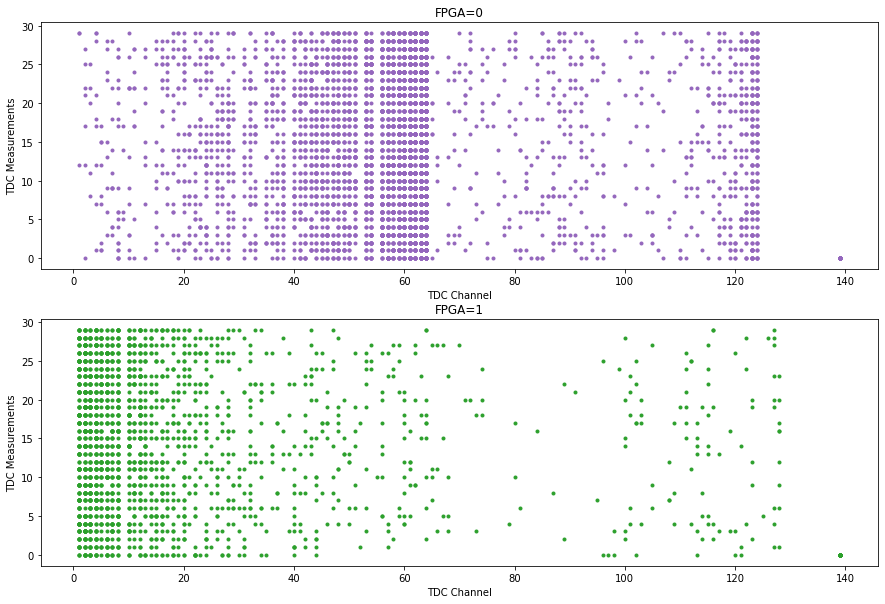


8) Top 3 noisy channels 
              HEAD  FPGA   ORBIT_CNT  BX_COUNTER  TDC_MEAS  Absolute time (ns)
TDC_CHANNEL                                                                  
127             1     1  3869200243        3337        29        7.460992e+06
128             1     1  3869200245        3337        23        7.680010e+06
139             1     1  3869200246        3559         0        7.809800e+06

9) Number of unique orbits: 89 
 Number of unique orbits with TDC_CHANNEL=139: 82


In [14]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as pl

#1)
dat=pd.read_csv("C:\\Users\\Utente\\Desktop\\Lab Of Computational Physics\\data_000637.txt")
#N=npr.randint(10000, len(dat))
###
N=8001
###
df=dat[0:N]
print("1) \n", df)

print("")

#2)    
x=1

for i in range(len(df)-1):
    if df['ORBIT_CNT'][i]!=df['ORBIT_CNT'][i+1]:
        if df['BX_COUNTER'][i]>x:
            x=df['BX_COUNTER'][i]
        else:
            x=df['BX_COUNTER'][i+1]
        
print("2) Number of bx counts in an orbit:", x)

print("")

#3)
time=0.0

for i in range(len(df)):
    time=time+25.0*10e-9*(float(df['BX_COUNTER'][i]))
    
print("3) Total time", time, "seconds")

print("")

#4)
df['Absolute time (ns)']=None
df['Absolute time (ns)'][0]=25./30.*df['TDC_MEAS'][0]+25*df['BX_COUNTER'][0]

ore=0
c=0

for i in range(1, len(df)):
    sec=25./30.*df['TDC_MEAS'][i]
    minut=25*df['BX_COUNTER'][i]
    if df['ORBIT_CNT'][i]!=df['ORBIT_CNT'][i-1]:
        c=c+1
        ore=x*25*c
    t=sec+minut+ore
    df['Absolute time (ns)'][i]=t
    
print("4) \n", df)
    
print("")

#5)
for i in range(len(df)):
    df.loc[i, 'HEAD']=npr.randint(0, 2)

print("5) \n", df.iloc[:, 0])

print("")

#6)
df2=df[df['HEAD']==1]

print("6) Data frame with only rows HEAD=1 \n", df2)

print("")

#7)
df_0=df[df['FPGA']==0]
df_1=df[df['FPGA']==1]

pl.figure(figsize=(15, 10))

zero=pl.subplot(2, 1, 1)
zero.plot(df_0['TDC_CHANNEL'], df_0['TDC_MEAS'], '.', color='C4')
zero.set_xlabel('TDC Channel')
zero.set_ylabel('TDC Measurements')
zero.set_title("FPGA=0")

one=pl.subplot(2, 1, 2)
one.plot(df_1['TDC_CHANNEL'], df_1['TDC_MEAS'], '.', color='C2')
one.set_xlabel('TDC Channel')
one.set_ylabel('TDC Measurements')
one.set_title("FPGA=1")

print("7)")
pl.show()

print("")

#8)

df3=df.groupby('TDC_CHANNEL').max()
print("8) Top 3 noisy channels \n", df3[-3:])

print("")

#9)

c=1 #counter for unique orbits
cc=1 #counter for unique orbits with TDC_CHANNEL=139 
f=0 #flag

for i in range(1, len(df)):
    if df['ORBIT_CNT'][i]!=df['ORBIT_CNT'][i-1]:
        c=c+1
        f=0
    if df['TDC_CHANNEL'][i]==139 and f==0:
        cc=cc+1
        f=1    
    
print("9) Number of unique orbits:", c, "\n", "Number of unique orbits with TDC_CHANNEL=139:", cc)